In [1]:
from obspy import read_events, Catalog, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geothermie_plot_function import *

In [2]:
threshold_event_magnitude = 0.5

In [3]:
catalog = read_events('Downloads/geothermie-events-master/geothermie-events-master/Unterhaching/*.xml')
catnew = Catalog()
cat2013 = Catalog()
eventinfo = []
eventinfo2 = []
for event in catalog:
    try:
        if not (event.origins[0]['time'] > UTCDateTime(2013,1,1) and event.origins[0]['time'] < UTCDateTime(2014,1,1)):
            catnew.append(event)
            eventinfo.append([event.origins[0]['time'],event.magnitudes[0].mag])
        else:
            cat2013.append(event)
            eventinfo2.append([event.origins[0]['time'],event.magnitudes[0].mag])
    except:
        pass
catalog = catnew
roundedtimes = []
magnitudes = []
for time in eventinfo:
    rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
    roundedtimes.append(rtime)
    magnitudes.append(time[1])
roundedtimes, magnitudes = zip(*sorted(zip(roundedtimes, magnitudes)))
print(catalog)
names = 'Time,Flowrate,Temperature,Pressure'
names = names.split(",")
data = pd.read_csv('Dokumente/unterhaching_betriebsdaten_2008-2017/daten20082017.txt',names=names,skiprows=1,delimiter=' ')
N = len(data)
newcol = np.zeros(N)
newcol2 = np.zeros(N)
flc = np.zeros(N)
tc = np.zeros(N)
pc = np.zeros(N)

ievent = 0

eventtimes = np.zeros(N)
eventtimes[0] = 100*365*24
eventtimes[1] = eventtimes[0]+1
newcol2[0] = np.nan
for i in range(1,N):
    if data['Time'][i] in roundedtimes:
        newcol[i] = 1
        N_events_in_this_hour = roundedtimes.count(data['Time'][i])
        
        ## get top magnitude of events in this hour
        mag = max(magnitudes[ievent:ievent+N_events_in_this_hour])
        newcol2[i] = mag
        if mag > threshold_event_magnitude:
            eventtimes[i+1] = 0
        else:
            eventtimes[i+1] = eventtimes[i]+1
        
        ievent += N_events_in_this_hour
    else:
        newcol2[i] = np.nan
        if i!=N-1:
            eventtimes[i+1] = eventtimes[i]+1
        
            
    
    if i==43022:
        roundedtimes2 = []
        magnitudes2 = []
        for time in eventinfo2:
            rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
            roundedtimes2.append(rtime)
            magnitudes2.append(time[1])
        roundedtimes2, magnitudes2 = zip(*sorted(zip(roundedtimes2, magnitudes2)))
        roundedtimes2 = list(roundedtimes2)
        magnitudes2 = list(magnitudes2)
        roundedtimes2.reverse()
        magnitudes2.reverse()
        check = True
        mag = -100
        eventindex = -1
        while (mag < threshold_event_magnitude and check):
            eventindex += 1
            mag = magnitudes2[eventindex]
            if eventindex==len(magnitudes2):
                check = False
        eventtimes[i] = (float(UTCDateTime(2014,1,1))-roundedtimes2[eventindex])/(60**2)

drop = []
for i in range(N):
    if np.isnan(data['Flowrate'][i]):
        drop.append(i)
data.drop(drop)
N = len(data)

for i in range(1,N-1):
    flc[i] = data['Flowrate'][i+1]-data['Flowrate'][i-1]
    tc[i] = data['Temperature'][i+1]-data['Temperature'][i-1]
    pc[i] = data['Pressure'][i+1]-data['Pressure'][i-1]
    

#data['Flowrate diff'] = flc/2
#data['Temp diff'] = tc/2
#data['Press diff'] = pc/2
data['Quiet time'] = eventtimes
data['Event'] = newcol
data['Magnitude'] = newcol2
names.extend(['Flowrate diff','Temp diff','Press diff','Quiet time','Event','Magnitude'])

509 Event(s) in Catalog:
2010-05-27T16:25:25.312700Z | +48.048,  +11.644 | 0.0839474806054 Ml
2010-01-31T08:00:57.025500Z | +48.048,  +11.643 | 0.039033276658 Ml
...
2019-01-18T21:53:12.483393Z | +48.049,  +11.646 | -0.472072504528 None
2019-12-31T17:47:30.953434Z | +48.045,  +11.644 | -0.497145528261 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [4]:
def Confusionmatrix(y,yhat,perc):
    N = len(y)
    C = [[0,0],[0,0]]
    for i in range(N):
        if y[i,0]==1. and yhat[i,0]>=perc:
            C[0][0] += 1
        elif y[i,0]==0. and yhat[i,0]>=perc:
            C[1][0] += 1
        elif y[i,0]==1. and yhat[i,0]<perc:
            C[0][1] += 1
        else:
            C[1][1] += 1
            
    print('True Positives:  ', C[0][0])
    print('False Positives: ', C[1][0])
    print('False Negatives: ', C[0][1])
    print('True Negatives:  ', C[1][1])
    return C

In [5]:
def plot_model_evolution(Loss,b,c,D,U,V,W):
    fig,ax = plt.subplots(nrows=7,figsize=(15,15),sharex=True)
    ax[0].plot(Loss,label='Loss')
    ax[0].set_yscale('log')
    ax[1].plot(c[:,0],label='c1')
    ax[1].plot(c[:,1],label='c2')
    ax[2].plot(b[:,0],label='b1')
    ax[2].plot(b[:,1],label='b2')
    ax[2].plot(b[:,2],label='b3')
    ax[3].plot(V[:,0,0],label='V11')
    ax[3].plot(V[:,0,1],label='V12')
    ax[3].plot(V[:,0,2],label='V13')
    ax[3].plot(V[:,1,0],label='V21')
    ax[3].plot(V[:,1,1],label='V22')
    ax[3].plot(V[:,1,2],label='V23')
    
    ulabels = [['U11','U12','U13'],['U21','U22','U23'],['U31','U32','U33']]
    wlabels = [['W11','W12','W13'],['W21','W22','W23'],['W31','W32','W33']]
    
    for i in range(3):
        for j in range(3):
            ax[4].plot(U[:,i,j],label=ulabels[i][j])
            ax[5].plot(W[:,i,j],label=wlabels[i][j])
        
    dlabels = [['D11','D12','D13'],['D21','D22','D23'],['D31','D32','D33']]
    for i in range(3):
        for j in range(3):
            ax[6].plot(D[:,i,j],label=dlabels[i][j])
            
    for i in range(7):
        ax[i].legend(fontsize=8)
    plt.show() 

In [6]:
def softmax(xx):
    z = np.zeros(len(xx))
    summa = 0
    for i in range(len(xx)):
        z[i] = np.exp(xx[i])
        summa += np.exp(xx[i])
    return z/summa

In [7]:
def ReLu(xx):
    zz = np.zeros(len(xx))
    for i in range(len(xx)):
        if xx[i]>0:
            zz[i] = xx[i]
    return zz

In [8]:
def delta(xx,yy):
    if xx==yy:
        return 1.
    else:
        return 0.

In [16]:
def initialization(Nit,Nd,Vpast):

    U = np.zeros((Nit,3,3))
    W = np.zeros((Nit,3,3,Nd))
    b = np.zeros((Nit,3,Nd))
    V = np.zeros((Nit,2,3,Vpast))
    c = np.zeros((Nit,2))
    D = np.zeros((Nit,3,3,Nd-1))

    dU = np.zeros((Nit,3,3))
    dW = np.zeros((Nit,3,3,Nd))
    db = np.zeros((Nit,3,Nd))
    dV = np.zeros((Nit,2,3,Vpast))
    dc = np.zeros((Nit,2))
    dD = np.zeros((Nit,3,3,Nd-1))

    yhat = np.zeros((Nit+1,N,2))

    Nrandom = 1000

    for i in range(3):
        for j in range(3):
            U[0,i,j] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
            for k in range(Nd):
                W[0,i,j,k] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom
            for k in range(Nd-1):
                D[0,i,j,k] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom
        for k in range(Nd):
            b[0,i,k]= (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom  
    for i in range(2):
        for j in range(3):
            for k in range(Vpast):
                V[0,i,j,k] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
        c[0,i] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom     

    Loss = np.zeros(Nit)

    return U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss,D,dD

In [24]:
def prediction(b,c,D,U,V,W,x):
    N = len(x)
    Nd = np.shape(D)[2]+1
    Vpast = np.shape(V)[2]
    a = np.zeros((N,3,Nd))
    h = np.zeros((N,3,Nd))
    o = np.zeros((N,2))
    yhat = np.zeros((N,2))
    a[0,:,0] = b[:,0] + np.dot(U,x[0])
    h[0,:,0] = np.tanh(a[0,:,0])
    for d in range(1,Nd):
        a[0,:,d] = b[:,d] + np.dot(D[:,:,d-1],h[0,:,d-1])
        h[0,:,d] = np.tanh(a[0,:,d])
    o[0] = c + np.dot(V[:,:,0],h[0,:,Nd-1])
    yhat[0] = softmax(o[0,:])
    
    for t in range(1,Vpast):
        a[t,:,0] = b[:,0] + np.dot(W[:,:,0],h[t-1,:,0])+np.dot(U,x[t])
        h[t,:,0] = np.tanh(a[t,:,0])
        for d in range(1,Nd):
            a[t,:,d] = b[:,d] + np.dot(W[:,:,d],h[t-1,:,d]) + np.dot(D[:,:,d-1],h[t,:,d-1])
            h[t,:,d] = np.tanh(a[t,:,d])
        hidden = np.zeros(2)
        for j in range(t):
            hidden += np.dot(V[:,:,t-(j+1)],h[j,:,Nd-1])
        o[t] = c + hidden
        yhat[t,:] = softmax(o[t,:])
    
    for t in range(Vpast,N):
        a[t,:,0] = b[:,0] + np.dot(W[:,:,0],h[t-1,:,0])+np.dot(U,x[t])
        h[t,:,0] = np.tanh(a[t,:,0])
        for d in range(1,Nd):
            a[t,:,d] = b[:,d] + np.dot(W[:,:,d],h[t-1,:,d]) + np.dot(D[:,:,d-1],h[t,:,d-1])
            h[t,:,d] = np.tanh(a[t,:,d])
        hidden = np.zeros(2)
        for j in range(Vpast):
            hidden += np.dot(V[:,:,Vpast-(j+1)],h[t-Vpast+j,:,Nd-1])
        o[t] = c + hidden
        yhat[t,:] = softmax(o[t,:])
    return h,o,yhat

def get_loss(y,yhat):
    N = len(y)
    Loss = 0
    for t in range(N):
        Loss -= y[t,0]*np.log10(yhat[t,0])+(1-y[t,0])*np.log10(yhat[t,1])
    return Loss

def gradients(D,h,o,V,W,x,y,yhat):
    N = len(x)
    Nd = np.shape(W)[2]
    Vpast = np.shape(V)[2]
    do = np.zeros((N,2))
    for t in range(N):
        do[t,0] = y[t,0]*(1-yhat[t,0])-yhat[t,0]*(1-y[t,0])
        do[t,1] = -y[t,0]*yhat[t,1] * (1-y[t,0])*(1-yhat[t,1])
    do /= np.log(10)
    
    dh = np.zeros((N,3,Nd))
    dh[-1,:,Nd-1] = np.dot(V[:,:,0].transpose(),do[-1])
    for d in range(Nd-2,-1,-1):
        diag = []
        for i in range(3):
            diag.append(1-h[-1,i,d+1]**2)
        diag = np.diag(np.array(diag))
        dh[-1,:,d] = np.dot(D[:,:,d].transpose(),np.dot(diag,dh[-1,:,d+1]))
        
    for t in range(N-2,N-1-Vpast,-1):
        diag = []
        for i in range(3):
            diag.append(1-h[t+1,i,Nd-1]**2)
        diag = np.diag(np.array(diag)) 
        hidden = np.zeros(3)
        for j in range(N-t):
            hidden += np.dot(V[:,:,j].transpose(),do[t+j])
        dh[t,:,Nd-1] = hidden+np.dot(W[:,:,Nd-1].transpose(),np.dot(diag,dh[t+1,:,Nd-1]))                    
        for d in range(Nd-2,-1,-1):
            diag = []
            diag2 = []
            for i in range(3):
                diag.append(1-h[t,i,d+1]**2)
                diag2.append(1-h[t+1,i,d]**2)
            diag = np.diag(np.array(diag))
            diag2 = np.diag(np.array(diag2))
            dh[t,:,d] = np.dot(D[:,:,d].transpose(),np.dot(diag,dh[t,:,d+1])) + \
                        np.dot(W[:,:,d].transpose(),np.dot(diag2,dh[t+1,:,d]))
    
    for t in range(N-Vpast-1,-1,-1):
        diag = []
        for i in range(3):
            diag.append(1-h[t+1,i,Nd-1]**2)
        diag = np.diag(np.array(diag))     
        hidden = np.zeros(3)
        for j in range(Vpast):
            hidden += np.dot(V[:,:,j].transpose(),do[t+j])
        dh[t,:,Nd-1] = hidden+np.dot(W[:,:,Nd-1].transpose(),np.dot(diag,dh[t+1,:,Nd-1]))        
        for d in range(Nd-2,-1,-1):
            diag = []
            diag2 = []
            for i in range(3):
                diag.append(1-h[t,i,d+1]**2)
                diag2.append(1-h[t+1,i,d]**2)
            diag = np.diag(np.array(diag))
            diag2 = np.diag(np.array(diag2))
            dh[t,:,d] = np.dot(D[:,:,d].transpose(),np.dot(diag,dh[t,:,d+1])) + \
                        np.dot(W[:,:,d].transpose(),np.dot(diag2,dh[t+1,:,d]))

    dc = np.zeros(2)
    for i in range(2):
        dc[i] = np.sum(do[:,i])
    db = np.zeros((3,Nd))
    dV = np.zeros((2,3,Vpast))
    dW = np.zeros((3,3,Nd))
    dD = np.zeros((3,3,Nd-1))
    dU = np.zeros((3,3))
    
    for i in range(3):
        for d in range(Nd):
            for t in range(N):
                db[i,d] += (1-h[t,i,d]**2)*dh[t,i,d]
    
    for k in range(Vpast):
        for t in range(Vpast,N):
            for i in range(2):
                for j in range(3):
                    dV[i,j,k] += do[t,i]*h[t-k,j,Nd-1]
        
    for t in range(1,N):
        mat2 = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                mat2[i,j] = dh[t,i,0] * x[t,j]
        dU += np.dot(np.diag(np.array([1-h[t,0,0]**2,1-h[t,1,0]**2,1-h[t,2,0]**2])),mat2)
        
    for d in range(Nd-1):
        for t in range(N):
            mat = np.zeros((3,3))
            for i in range(3):
                for j in range(3):
                    mat[i,j] = dh[t,i,d+1] * h[t,j,d]
            dD[:,:,d] += np.dot(np.diag(np.array([1-h[t,0,d+1]**2,1-h[t,1,d+1]**2,1-h[t,2,d+1]**2])),mat)
    
    for d in range(Nd):
        for t in range(1,N):
            mat = np.zeros((3,3))
            for i in range(3):
                for j in range(3):
                    mat[i,j] = dh[t,i,d] * h[t-1,j,d]
            dW[:,:,d] += np.dot(np.diag(np.array([1-h[t,0,d]**2,1-h[t,1,d]**2,1-h[t,2,d]**2])),mat)
    return db,dc,dD,do,dU,dV,dW

In [11]:
def mapx(x):
    Nt, Ni = np.shape(x)
    m = np.zeros((Ni,2))
    for i in range(Ni):
        m[i,0] = np.min(x[:,i])
        m[i,1] = np.max(x[:,i])
    newx = np.zeros(np.shape(x))
    for i in range(Ni):
        for t in range(Nt):
            newx[t,i] = (x[t,i]-m[i,0])/(m[i,1]-m[i,0])
    return newx

In [78]:
#data acquisition
N = len(data)
x = [[],[],[]]
y = [[],[]]
index = 0
for i in range(N):
    if not np.isnan(data['Flowrate'][i]):
        x[0].append(data['Flowrate'][i])
        x[1].append(data['Temperature'][i])
        x[2].append(data['Pressure'][i])
        y[0].append(data['Event'][i])
        y[1].append(data['Magnitude'][i])
x = np.array(x).transpose()
y = np.array(y).transpose()
x = mapx(x)
N = len(x)

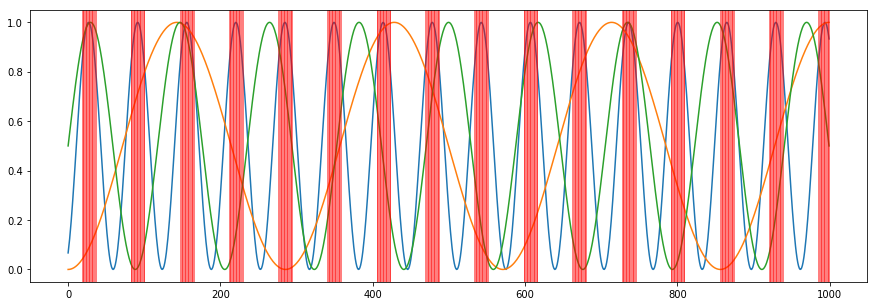

In [142]:
#fake data
N = 1000
x = np.zeros((N,3))
y = np.zeros((N,2))
x[:,0] = (np.sin(np.linspace(0,31*np.pi,N)-np.pi/3)+1)/2
x[:,1] = (np.sin(np.linspace(0,7*np.pi,N)-np.pi/2)+1)/2
x[:,2] = (np.sin(np.linspace(0,17*np.pi,N))+1)/2
plt.figure(figsize=(15,5))
plt.plot(x[:,0])
plt.plot(x[:,1])
plt.plot(x[:,2])
xx = []
yy = []
for i in range(1,N):
    if x[i,0]>0.8:
        y[i,0] = 1.
        xx.append(i)
        yy.append(np.max(x[i,0]))
        plt.axvline(i,lw=0.5,c='r')
#plt.scatter(xx,yy,c='r',marker='X')
plt.show()
x = mapx(x)

### RNN-model, fig. 10.4

Adding more depth to the neural network by adding hidden layers. Also, past deep hidden layers contribute to current estimation. 

Training may be hard, as there's a tendency for Vs to grow linearly and therefore the Loss increases exponentially.

In [143]:
Nit = 1000
eps = 0.0001
Vpast = 2
Nd = 5

U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss,D,dD = initialization(Nit,Nd,Vpast)

for k in range(Nit):
    h,o,yhat[k] = prediction(b[k],c[k],D[k],U[k],V[k],W[k],x)
    Loss[k] = get_loss(y,yhat[k])
    print(k,Loss[k])
    db[k],dc[k],dD[k],do,dU[k],dV[k],dW[k] = gradients(D[k],h,o,V[k],W[k],x,y,yhat[k])
    
    if k+1<Nit:
        U[k+1] = U[k] + eps*dU[k]
        W[k+1] = W[k] + eps*dW[k]
        V[k+1] = V[k] + eps*dV[k]
        b[k+1] = b[k] + eps*db[k]
        c[k+1] = c[k] + eps*dc[k]
        D[k+1] = D[k] + eps*dD[k]

0 810.653097405
1 771.362587222
2 733.807316798
3 698.086951987
4 664.251969328
5 632.316804759
6 602.271371451
7 574.089349588
8 547.73328757
9 523.157318482
10 500.308438895
11 479.12712951
12 459.547836171
13 441.499587874
14 424.906847506
15 409.690576205
16 395.769433229
17 383.061014815
18 371.483043068
19 360.954437055
20 351.396223701
21 342.732269927
22 334.889836323
23 327.799965685
24 321.397727108
25 315.622339276
26 310.417196442
27 305.729818524
28 301.511743866
29 297.718380081
30 294.308825479
31 291.245671059
32 288.494790901
33 286.025127132
34 283.808474239
35 281.819266407
36 280.034370723
37 278.432888297
38 276.995964832
39 275.706611649
40 274.549537778
41 273.510993413
42 272.57862477
43 271.741340148
44 270.989186872
45 270.31323867
46 269.705492922
47 269.15877722
48 268.666664599
49 268.22339682
50 267.823815082
51 267.463297541
52 267.137703077
53 266.843320728
54 266.5768243
55 266.335231643
56 266.115868171
57 265.916334195
58 265.734475707
59 265.56835826

465 36.6279028267
466 43.8317634126
467 35.9705010177
468 42.7035987166
469 35.3713172819
470 41.768293482
471 34.9222581502
472 41.2494231848
473 34.6993586324
474 41.3103961946
475 34.7179324309
476 41.9534051401
477 34.9454717764
478 43.0761861425
479 35.3438751096
480 44.5932829455
481 35.8796232893
482 46.4529022422
483 36.4861628597
484 48.4936825789
485 36.9505827899
486 50.0384011309
487 36.7918501716
488 49.5072072221
489 35.5801952478
490 45.5662651096
491 33.0021390856
492 38.1278040164
493 29.2500798534
494 30.1461945048
495 28.8963330108
496 31.335726349
497 32.3575309847
498 41.0498503792
499 36.0811447984
500 50.8170001529
501 40.1140008156
502 61.7827404902
503 34.5390622606
504 42.48190504
505 28.6388638029
506 29.146794018
507 25.6866615141
508 25.4415893095
509 26.9628496062
510 29.5761333183
511 34.3029551372
512 47.2470247543
513 43.3220170278
514 67.5331900427
515 32.2844867175
516 37.1672089763
517 25.1791133241
518 24.7061455456
519 24.0674625198
520 23.87402828

923 9.24208621551
924 9.2255928992
925 9.20917701769
926 9.19283788103
927 9.17657479173
928 9.16038708259
929 9.14427406954
930 9.12823510963
931 9.11226952871
932 9.0963767108
933 9.08055598668
934 9.06480677209
935 9.04912839525
936 9.03352031163
937 9.01798183538
938 9.00251247479
939 8.98711151208
940 8.97177852963
941 8.95651274954
942 8.94131386273
943 8.92618098625
944 8.91111397544
945 8.89611177016
946 8.88117448075
947 8.86630075347
948 8.85149110093
949 8.83674368687
950 8.82205966638
951 8.80743641272
952 8.79287611639
953 8.77837485608
954 8.76393650284
955 8.74955501234
956 8.73523699897
957 8.72097292867
958 8.70677391633
959 8.69262467505
960 8.67854373571
961 8.66450629751
962 8.65054316164
963 8.63661374081
964 8.62276921714
965 8.60894271897
966 8.59521940709
967 8.5814884961
968 8.56789199966
969 8.55424551329
970 8.54078651088
971 8.52720674997
972 8.51390454057
973 8.50036262688
974 8.48725121789
975 8.47369911658
976 8.46083770952
977 8.44719448248
978 8.4346855

In [144]:
bestindex = np.argmin(Loss)
#bestindex = 257

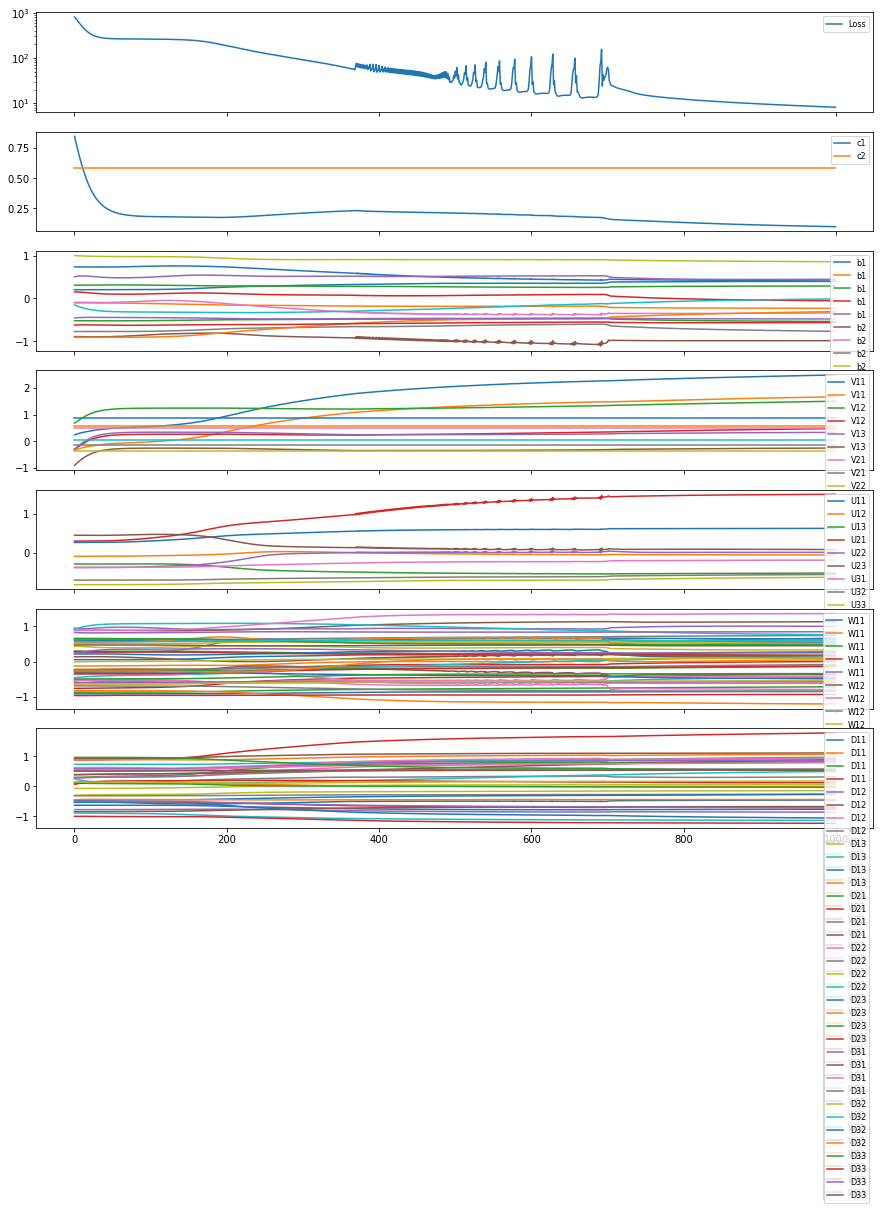

In [145]:
plot_model_evolution(Loss,b,c,D,U,V,W)

In [146]:
_,_,pred = prediction(b[bestindex],c[bestindex],D[bestindex],U[bestindex],V[bestindex],W[bestindex],x)

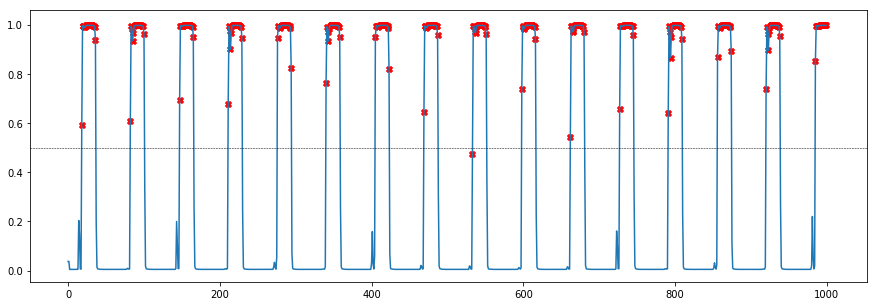

True Positives:   299
False Positives:  0
False Negatives:  1
True Negatives:   700
#############
8.09768305802


In [149]:
q = 0.5

plt.figure(figsize=(15,5))
plt.plot(pred[:,0])
for i in range(N):
    if y[i,0]==1.:
        plt.scatter(i,pred[i,0],c='r',marker='X')
plt.axhline(q,lw=0.5,ls='dashed',c='k')
#plt.yscale('log')
plt.show()

C = Confusionmatrix(y,pred,q)

print('#############')
print(Loss[bestindex])